In [1]:
#setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib as mpl
import itertools as it
mpl.rcParams['pdf.fonttype'] = 42


def get_colormap(colors, N = 256):
    return clr.LinearSegmentedColormap.from_list('custom', colors, N=N) if len(colors) > 1 else plt.get_cmap(*colors)


def get_bin_index(site, leftBound, rightBound, binsize):
    binbounds = np.arange(leftBound, rightBound, binsize)
    # -1 because 0-based indices
    return len(np.where(binbounds < site)[0]) - 1 \
           if not (site < binbounds[0] or site > binbounds[-1]) \
           else None


def annotate_contacts(ax, 
                      contacts, 
                      r = 2.5, 
                      linestyle = '--', 
                      edgecolor = 'k',
                      mirror_horizontal = False):
    t = np.array([[1, 0.5], [-1, 0.5]]) if mirror_horizontal else np.array([[-1, 0.5], [1, 0.5]])
    
    for x, y in contacts:
        M = np.array([[x, y]])
        M = np.dot(M, t)
        ax.add_patch(patches.Circle((M[:, 1], M[:, 0]), 
                                    radius = r,
                                    fill = False,
                                    ls = linestyle,
                                    edgecolor = edgecolor,
                                    zorder = 3))


def plot_matrix(ax,
                mat,
                cmap,
                xrange,
                scaling=1000,
                capturebins=None,
                highlightbins=None,
                xlabel=None,
                xticknum=0,
                cbarwidth=0.025,
                vmin=0,
                vmax=50,
                mirror_horizontal=False,
                subplot_label=None):
    '''
    plotting function for triC results

    :param ax:                  plt.Axes object to generate the plot in
    :param mat:                 TriC matrix as generated by the CCseq pipeline
    :param cmap:                colormap to use for plotting
    :param xrange:              tuple of integer coordinates in bp of the genomic region plotted in the matrix
    :param scaling:             divisor for scaling the xrange
    :param capturebins:         bins containing the capture probes (optional)
    :param highlightbins:       list of tuples of startbin, endbin and highlightcolor for bins to highlight
                                if endbin == startbin only the startbin will be highlighted
    :param xlabel:              xaxis label
                                the annotation given at index -1 will be the bottom most annotation
    :param xticknum:            number of xticks to plot. xticklabels will be interpolated with np.linspace
    :param cbarwidth:           width of the colorbar as fraction of x-axis length
    :param vmin:                minimum value of the colormap
    :param vmax:                maximum value of the colormap
    :param mirror_horizontal:   indicates if generated matrix plot should be mirrored at a horizontal line

    :return:                    plt.Axes
    '''

    xrange = (xrange[0] / scaling, xrange[1] / scaling)

    N = mat.shape[0]
    # Get the lower triangle of the matrix.
    C = np.triu(mat)
    # Mask the upper triangle
    C = np.ma.masked_array(C, C == 0)

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1, 0.5], [-1, 0.5]]) if not mirror_horizontal else np.array([[-1, 0.5], [1, 0.5]])
    A = np.dot(A, t)

    # Plot the heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)
    mesh = ax.pcolormesh(X, Y, np.flipud(C), cmap=cmap, vmin=vmin, vmax=vmax, zorder=2)

    # mark bin containing capturesite in grey
    if capturebins:
        greymap = clr.LinearSegmentedColormap.from_list('greymap', ['Grey', 'Grey'], N=256)
        capturemat = np.zeros(shape=mat.shape)
        for capturebin in capturebins:
            if capturebin is not None:
                capturemat[capturebin, :] = 1
                capturemat[:, capturebin] = 1

        capturemat = np.triu(capturemat)
        capturemat = np.ma.masked_array(capturemat, capturemat == 0)
        capturemesh = ax.pcolormesh(X, Y, np.flipud(capturemat), cmap=greymap, vmin=0, vmax=1, zorder=3)

    if highlightbins:
        for hlstartbin, hlendbin, hlclr in highlightbins:
            hlmap = clr.LinearSegmentedColormap.from_list(hlclr, [hlclr, hlclr], N=256)
            hlmat = np.zeros(shape=mat.shape)
            if not hlendbin == None:
                hlidx = np.arange(hlstartbin, hlendbin + 1)
            else:
                hlidx = hlstartbin

            hlmat[hlidx, :] = 1
            hlmat[:, hlidx] = 1
            hlmat = np.triu(hlmat)
            hlmat = np.ma.masked_array(hlmat, hlmat == 0)
            hlmesh = ax.pcolormesh(X, Y, np.flipud(hlmat), cmap=hlmap, vmin=0, vmax=1, alpha=0.2, zorder=1)

    # draw outlines of triangle plot
    vertices = np.array([[0, 0], [N / 2, N], [N, 0]]) if not mirror_horizontal else np.array(
        [[0, 0], [N / 2, -N], [N, 0]])
    triangle = patches.Polygon(vertices, fill=False, edgecolor='black')
    ax.add_patch(triangle)

    ax.set_xlim(left=0, right=N)

    if not mirror_horizontal:
        ax.set_ylim(bottom=0, top=N)

    else:
        ax.set_ylim(bottom=-N, top=0)

    if not mirror_horizontal:
        for loc in ['left', 'right', 'top']:
            ax.spines[loc].set_visible(False)

    else:
        for loc in ['left', 'right', 'bottom']:
            ax.spines[loc].set_visible(False)

        ax.xaxis.tick_top()

    ax.set_yticks([])
    ax.set_xticks([])

    if xticknum:
        ax.set_xticks(np.linspace(0, N, xticknum))
        ax.set_xticklabels(['{val:,}'.format(val=i) for i in np.linspace(xrange[0], xrange[1], xticknum, dtype=int)])

    if xlabel:
        ax.set_xlabel(xlabel)

    # plot colorbar
    rect = patches.Rectangle((N - N * cbarwidth, N / 2), N * cbarwidth, N / 2, fill=False, edgecolor='black') \
        if not mirror_horizontal else \
        patches.Rectangle((N - N * cbarwidth, -N), N * cbarwidth, N / 2, fill=False, edgecolor='black')

    ax.add_patch(rect)

    cbarY = np.tile(np.linspace(N / 2, N, cmap.N).reshape(-1, 1), 2) \
        if not mirror_horizontal else \
        np.tile(np.linspace(-N, -N / 2, cmap.N).reshape(-1, 1), 2)
    cbarX = np.tile(np.array([N - N * cbarwidth, N]), (cbarY.shape[0], 1))
    cbarmesh = ax.pcolormesh(cbarX, cbarY, np.linspace(0, 1, cmap.N - 1).reshape(-1, 1), cmap=cmap, vmin=0, vmax=1)

    ys = np.linspace(N / 2, N, 5) if not mirror_horizontal else np.linspace(-N, -N / 2, 5)
    for y, cmapval in zip(ys, np.linspace(vmin, vmax, 5)):
        ax.add_line(
            Line2D([N - N * cbarwidth - N * 0.005, N - N * cbarwidth], [y, y], color='black', lw=mpl.rcParams['patch.linewidth']))
        ax.text(N - N * cbarwidth - N * 0.0075, y, '{:.01f}'.format(cmapval), ha='right', va='center')

    ax.text(N + 1, 3 * N / 4 if not mirror_horizontal else -3 * N / 4, 'RPM', ha='left', va='center', rotation=90)

    if subplot_label:
        ax.text(0, N if not mirror_horizontal else -N, subplot_label,
                ha='left',
                va='top' if not mirror_horizontal else 'bottom', fontsize=15)

    return ax


igh = (114435000, 114669000)
interacting_regions = {'3CBE': (114458995, 114463472),
                       '3CBEhs4': (114458995, 114466563), 
                       'Em': (114664789, 114666183),
                       'Sm': (114662156, 114664070),
                       'EmSm': (114662156, 114664070),
                       'SmCm': (114657164, 114664070),
                       'hs4': (114466346, 114466563),
                       'IgG1': (114577464, 114577709)}

In [2]:
# reading in samplenames and subset for IgG1 samples of mouse
samplenames = pd.read_csv('resource/sampleinfo_TriC_8.tsv', 
                          sep = '\t', 
                          header = None, 
                          names = ['name', 'capture', 'genome'])

samplenames = samplenames.loc[samplenames.capture.str.startswith('IgG1') & 
                              (samplenames.genome == 'mm9') &
                              ~samplenames.name.str.endswith('sort')] \
                         .reset_index(drop = True)
samplenames

,name,capture,genome
0,TriC_8_lane_2_EmuKO_d0_1,IgG1_pool_capture,mm9
1,TriC_8_lane_2_EmuKO_d0_2,IgG1_pool_capture,mm9
2,TriC_8_lane_2_EmuKO_d2_1,IgG1_pool_capture,mm9
3,TriC_8_lane_2_EmuKO_d2_2,IgG1_pool_capture,mm9
4,TriC_8_lane_2_Spt5_KO_3,IgG1_pool_capture,mm9
5,TriC_8_lane_2_Spt5_KO_4,IgG1_pool_capture,mm9
6,TriC_8_lane_2_Spt5_ctrl_1,IgG1_pool_capture,mm9
7,TriC_8_lane_2_Spt5_ctrl_3,IgG1_pool_capture,mm9
8,TriC_8_lane_2_priB2_d0_1,IgG1_pool_capture,mm9
9,TriC_8_lane_2_priB2_d0_2,IgG1_pool_capture,mm9


In [3]:
# reading matrices and setting capture bins to 0
mats = {}
cbinidx = get_bin_index(interacting_regions['IgG1'][0], igh[0], igh[1], 1000)
for name in samplenames.name:
    m = np.loadtxt(f'TriCplots/{name}_TriC_interactions_1000_RAW.tab',
                   delimiter = '\t')
    m[cbinidx, :] = 0
    m[:, cbinidx] = 0
    mats[name] = m

In [4]:
def sum_contacts(m, contact_regions, total_region, binsize = 1000, r = 0):
    idxs = []
    contact_sum = 0
    
    for contact_region in it.combinations(contact_regions, 2):
        region_idxs = []
        for start, end in contact_region:
            width = end - start
            
            if r and width < binsize * (2 * r + 1):
                mid = start + (end - start)//2
                midbin = get_bin_index(mid, total_region[0], total_region[1], binsize)
                startbin = midbin - r
                endbin = midbin + r + 1
                
            else:
                startbin = get_bin_index(start, total_region[0], total_region[1], binsize)
                endbin = get_bin_index(end, total_region[0], total_region[1], binsize) + 1
            
            region_idxs.append((startbin, endbin))
            
        contact_sum += m[region_idxs[0][0]: region_idxs[0][1], region_idxs[1][0]: region_idxs[1][1]].sum()
        idxs.append(region_idxs)
    
    return contact_sum, idxs

In [5]:
regions1 = ['3CBE', '3CBEhs4', 'hs4']
regions2 = ['Em', 'Sm', 'EmSm', 'SmCm']
contactsums = []
for sample in samplenames.name:
    n = int(sample[-1:])
    name = sample[:-2]
    m = mats[sample]
    for region1, region2 in it.product(regions1, regions2):
        contact_sum, idxs = sum_contacts(m, 
                                         [interacting_regions[region1], 
                                          interacting_regions[region2]], 
                                         igh,
                                         r = 2)
        pcontacts = contact_sum/m.sum() * 100
        contactsums.append([name, n, region1, region2, pcontacts, pcontacts])
        
contactsums = pd.DataFrame(contactsums, columns = ['sample', 'replicate', 'region1', 'region2', 'pinteractions', 'std'])
contactsums

,sample,replicate,region1,region2,pinteractions,std
0,TriC_8_lane_2_EmuKO_d0,1,3CBE,Em,0.077616,0.077616
1,TriC_8_lane_2_EmuKO_d0,1,3CBE,Sm,0.077616,0.077616
2,TriC_8_lane_2_EmuKO_d0,1,3CBE,EmSm,0.077616,0.077616
3,TriC_8_lane_2_EmuKO_d0,1,3CBE,SmCm,0.061581,0.061581
4,TriC_8_lane_2_EmuKO_d0,1,3CBEhs4,Em,0.101808,0.101808
...,...,...,...,...,...,...
163,TriC_8_lane_2_priB2_d2,3,3CBEhs4,SmCm,0.076223,0.076223
164,TriC_8_lane_2_priB2_d2,3,hs4,Em,0.000000,0.000000
165,TriC_8_lane_2_priB2_d2,3,hs4,Sm,0.015624,0.015624
166,TriC_8_lane_2_priB2_d2,3,hs4,EmSm,0.015624,0.015624


,sample,replicate,region1,region2,pinteractions,std
0,TriC_8_lane_2_EmuKO_d0,1,3CBE,Em,0.077616,0.077616
12,TriC_8_lane_2_EmuKO_d0,2,3CBE,Em,0.000000,0.000000
24,TriC_8_lane_2_EmuKO_d2,1,3CBE,Em,0.042206,0.042206
36,TriC_8_lane_2_EmuKO_d2,2,3CBE,Em,0.055499,0.055499
48,TriC_8_lane_2_Spt5_KO,3,3CBE,Em,0.071063,0.071063
...,...,...,...,...,...,...
119,TriC_8_lane_2_priB2_d0,2,hs4,SmCm,0.000000,0.000000
131,TriC_8_lane_2_priB2_d0,3,hs4,SmCm,0.017399,0.017399
143,TriC_8_lane_2_priB2_d2,1,hs4,SmCm,0.034686,0.034686
155,TriC_8_lane_2_priB2_d2,2,hs4,SmCm,0.022149,0.022149


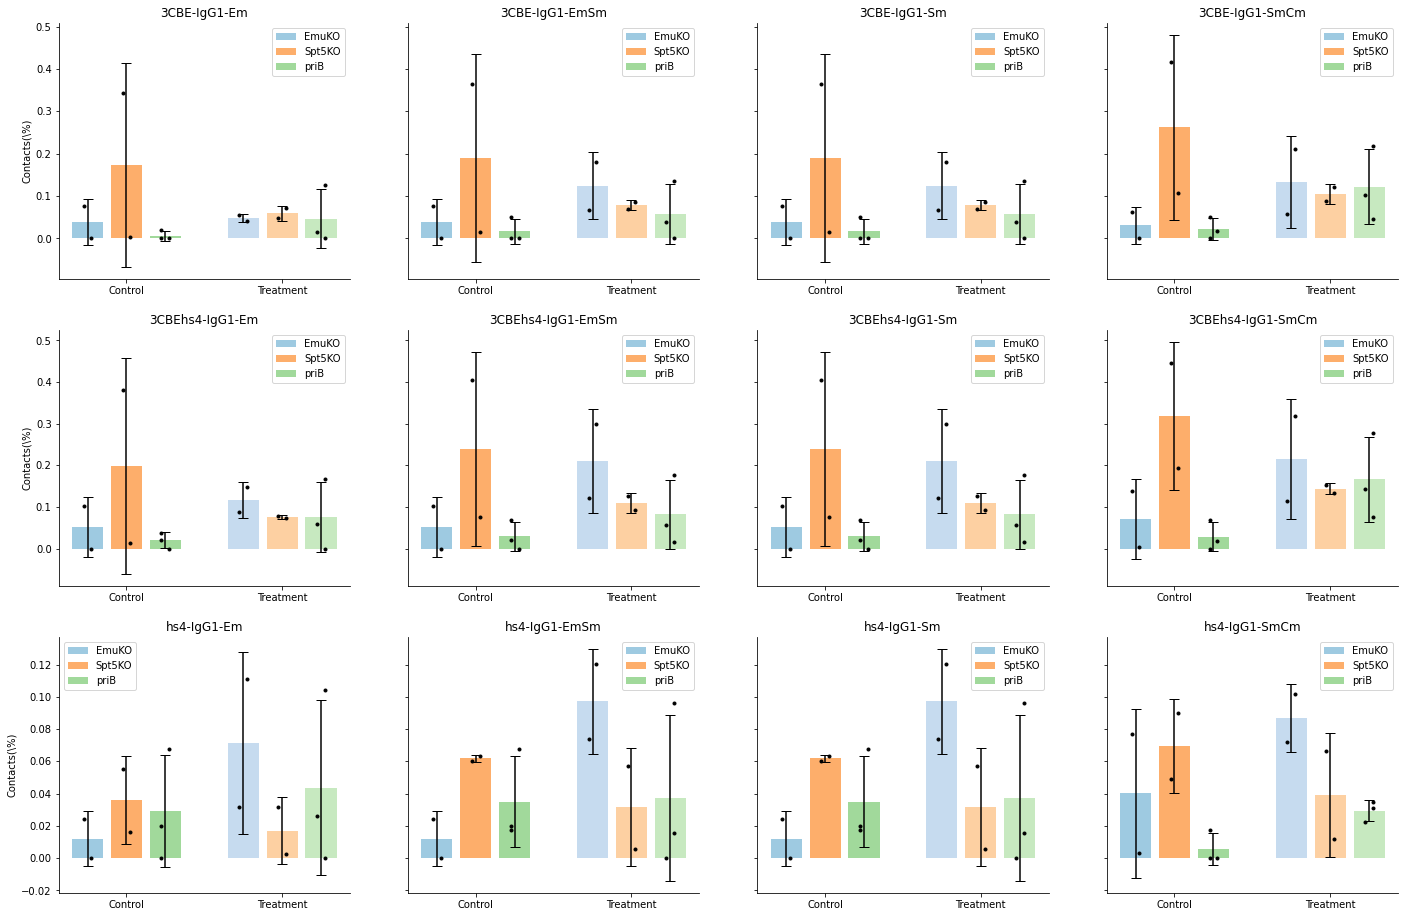

In [9]:
def jitter(points_x, points_y, offset = 0.1):
    jitter_x, jitter_y = [], []
    f = -1
    for x, y in zip(points_x, points_y):
        jitter_x.append(x + offset * f)
        jitter_y.append(y)
        f *= -1
    
    return jitter_x, jitter_y


fig, axs = plt.subplots(3, 4, sharey = 'row')
axs = axs.reshape(12)

sampleorder = ['TriC_8_lane_2_EmuKO_d0', 'TriC_8_lane_2_Spt5_ctrl', 'TriC_8_lane_2_priB2_d0',
               'TriC_8_lane_2_EmuKO_d2', 'TriC_8_lane_2_Spt5_KO', 'TriC_8_lane_2_priB2_d2']
cmap = plt.get_cmap('tab20c')
colors = [cmap(i) for i in [2, 6, 10, 3, 7, 11]]
for l, ax, (regions, group) in zip(range(12), axs, contactsums.groupby(['region1', 'region2'])):
    samplegroups = group.groupby('sample')
    x = [1, 2, 3, 5, 6, 7]
    y = [samplegroups.get_group(k).pinteractions.mean() for k in sampleorder]
    yerr = [samplegroups.get_group(k).pinteractions.std() for k in sampleorder]
    ax.bar(x, y, yerr = yerr, capsize = 5, color = colors)
    points_x, points_y = [], []
    for i, k in zip(x, sampleorder):
        tmp_y = list(samplegroups.get_group(k).pinteractions.values)
        points_x.extend([i for j in range(len(tmp_y))])
        points_y.extend(tmp_y)
    jitter_x, jitter_y = jitter(points_x, points_y)
    ax.plot(jitter_x, jitter_y, '.', c = 'k')
    
    legend_elements = [patches.Patch(facecolor = colors[i]) for i in range(3)]
    ax.legend(handles = legend_elements, labels = ['EmuKO', 'Spt5KO', 'priB'])
    ax.set_xticks([2, 6])
    ax.set_xticklabels(['Control', 'Treatment'])
    
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
    
    ax.set_title('-'.join([regions[0], 'IgG1', regions[1]]))
    if l in [0, 4, 8]:
        ax.set_ylabel('Contacts(\%)')
    
fig.set_figwidth(24)
fig.set_figheight(16)
fig.savefig('plots/contact_percents_2kb_radius.pdf')

[[0.839175351333258, 0.6246913004154172, 0.41675917555111663], [0.3494060330568658, 0.6355333382412666, 0.42404774847834625], [0.3494060330568658, 0.6355333382412666, 0.42404774847834625], [0.39167444851155, 0.4926911180677904, 0.18247075463657741], [0.39910791621942865, 0.6269916241104394, 0.3697801083538332], [0.28950109836608456, 0.5737529169165658, 0.38869858764398], [0.28950109836608456, 0.5737529169165658, 0.38869858764398], [0.3723922208677384, 0.39529672610869404, 0.1348627150078658], [0.3628161439075891, 0.5246200368233154, 0.7201050056125815], [0.1181755236604034, 0.4468938808970868, 0.9507319184236505], [0.1181755236604034, 0.4468938808970868, 0.9507319184236505], [0.4112182649873973, 0.47301800502101266, 0.03439037123760182]]


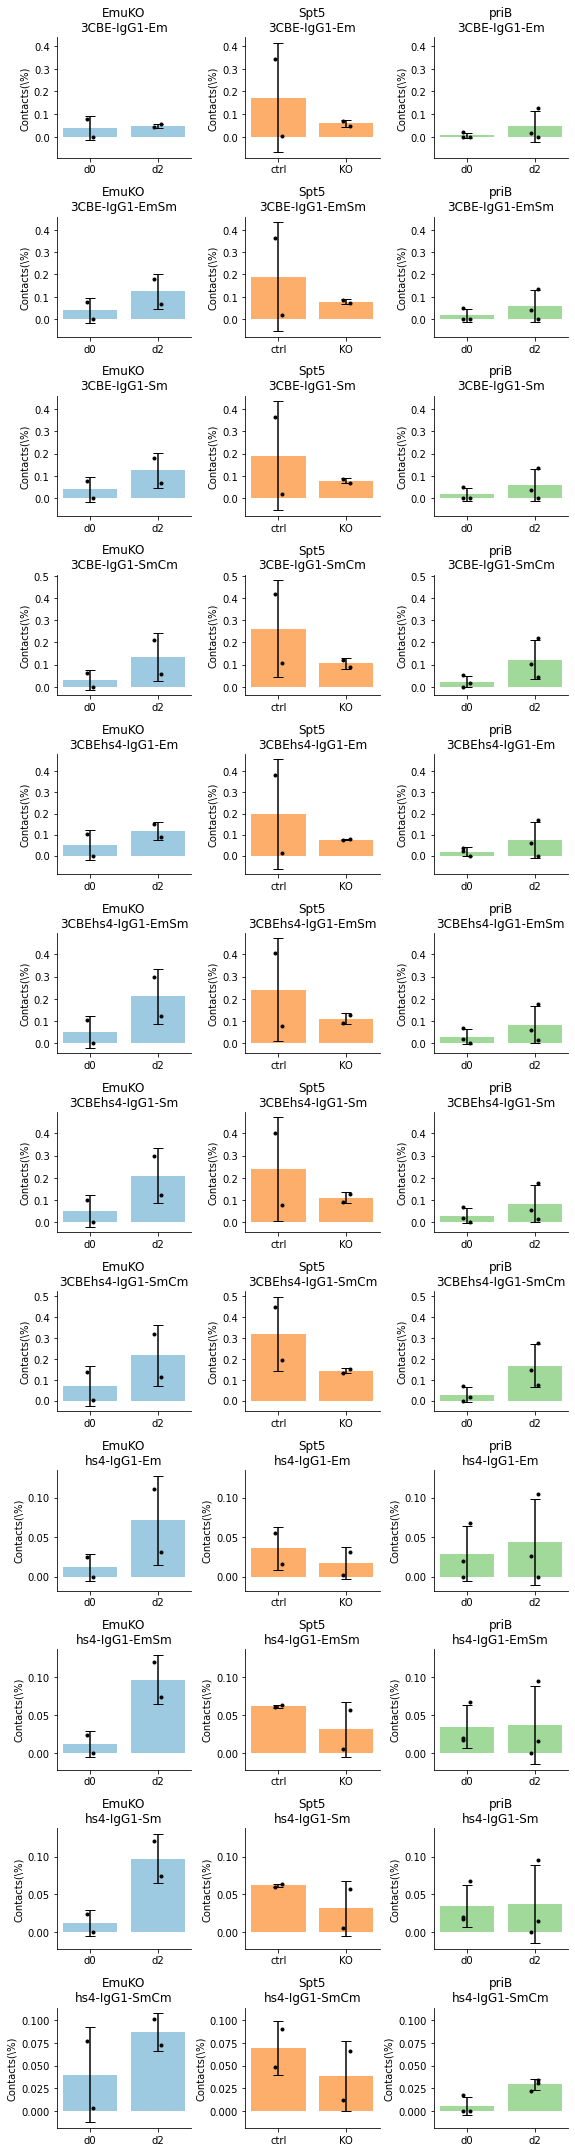

In [34]:
from scipy.stats import ttest_ind
fig, axs = plt.subplots(12, 3, sharey = 'row')
control = ['TriC_8_lane_2_EmuKO_d0', 'TriC_8_lane_2_Spt5_ctrl', 'TriC_8_lane_2_priB2_d0']
treatment = ['TriC_8_lane_2_EmuKO_d2', 'TriC_8_lane_2_Spt5_KO', 'TriC_8_lane_2_priB2_d2']

xticklabels = {'EmuKO': ['d0', 'd2'], 'Spt5': ['ctrl', 'KO'], 'priB': ['d0', 'd2']}
cmap = plt.get_cmap('tab20c')
colors = [cmap(i) for i in [2, 6, 10]]
ymaxs = []
ymins = []
pvals = []
for rowaxs, (regions, group) in zip(axs, contactsums.groupby(['region1', 'region2'])):
    samplegroups = group.groupby('sample')
    x = [1, 2]
    ymax_row = 0
    ymin_row = 1
    pvals_row = []
    for ax, samplepair, color in zip(rowaxs, zip(control, treatment), colors):
        yc = samplegroups.get_group(samplepair[0]).pinteractions.values
        yt = samplegroups.get_group(samplepair[1]).pinteractions.values
        t, p = ttest_ind(yc, yt, equal_var = False)
        pvals_row.append(p)
        
        y = [samplegroups.get_group(k).pinteractions.mean() for k in samplepair]
        yerr = [samplegroups.get_group(k).pinteractions.std() for k in samplepair]
        ax.bar(x, y, yerr = yerr, capsize = 5, color = color)
        points_x, points_y = [], []
        for i, k in zip(x, samplepair):
            tmp_y = list(samplegroups.get_group(k).pinteractions.values)
            points_x.extend([i for j in range(len(tmp_y))])
            points_y.extend(tmp_y)
        jitter_x, jitter_y = jitter(points_x, points_y, 0.05)
        ax.plot(jitter_x, jitter_y, '.', c = 'k')

        for pos in ['top', 'right']:
            ax.spines[pos].set_visible(False)
            
        ax.yaxis.set_tick_params(labelleft=True)
        
        name = samplepair[0].split('_')[-2]
        
        if name == 'priB2':
            name = 'priB'
            
        ymin, ymax = ax.get_ylim()
        
        if ymax > ymax_row:
            ymax_row = ymax
        
        if ymin < ymin_row:
            ymin_row = ymin
            
        ax.set_xticks(x)
        ax.set_xticklabels(xticklabels[name])
        ax.set_title(name + '\n' + '-'.join([regions[0], 'IgG1', regions[1]]))
        ax.set_ylabel('Contacts(\%)')
    
    ymaxs.append(ymax_row)
    ymins.append(ymin_row)
    pvals.append(pvals_row)

for rowaxs, rowpvals, ymax, ymin in zip(axs, pvals, ymaxs, ymins):
    for ax, pval in zip(rowaxs, rowpvals):
        if pval <= 0.05:
            ax.add_line(Line2D([1, 2], [ymax + 0.05] * 2))
#        
#        ax.set_ylim(ymin, ymax + 0.1)

print(pvals)
fig.set_figwidth(8)
fig.set_figheight(30)
fig.tight_layout()
fig.savefig('plots/contact_percents_single.pdf')